# Ammonia Synthesis 1D Reactor Model

Author: Andrea Giuseppe Landella

Disclaimer: THIS FILE IS PROVIDED AS-IS, WITHOUT WARRANTY OF ANY KIND, WITHOUT MAKING USE OR REFERENCE OF PROPRIETARY DATA.

## Industrial Reactor Model Type

The reactor model is set up by approximating the reaction flow a pseudo-homogeneous phase with the packed bed catalyst. This allows to write the energy balances with respect to the pseudophase temperature, which is approximately close to the bulk gas temperature and catalyst solid particle temperature. In other words, it is assumed that the heat transfer between the bulk gas phase and the catalyst solid is much faster than the heat generation rate from the reaction exothermicity. 

This is supported by experimental data from this source: [Ullmann, Ammonia Part II, tab. 5, p.152](https://doi.org/10.1002/14356007.o02_o11)

## Model Assumptions 

The main assumptions are:

- reaction stoichiometry of this form
$$
3\mathrm{H_2}+\mathrm{N_2}\to 2\mathrm{NH_3}
$$
- ideal mixture of real gases, containing N2, H2, NH3 and Ar
- pseudo-homogeneous reacting gas phase with the packed bed catalyst
- 1D plug flow model with constant cross-sectional area $A$, neglecting any radial gradients
- adiabatic operation of the reactor
- steady state operation of the reactor
- catalyst particles are considered as spheres
- constant catalyst density and void fraction
- Temkin rate law and parametrized catalyst effectiveness factor  

Tha reference paper of [Dyson et al., 1968](https://doi.org/10.1021/i160028a013) is the source for thermodynamics, kinetics, and catalyst properties, unless where otherwise specified, and it is based on available, published data. 

All the polynomial coefficients have been rounded up to 3 significant figures.

*Note: In the mid 1980's the Milan-born catalyst from Montecatini Edison (Agrimont S.p.A., Enimont Group) was patented, by the engineers Giorgio Gramatica and Nicola Pernicone.*

In [1]:
# math
import numpy as np
import scipy.optimize as optimz
import scipy.integrate as integr

# plot
import matplotlib.pyplot as plt
import matplotlib_inline
#
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# thermodynamic, transport and physical properties
import CoolProp.CoolProp as CP

import warnings
warnings.filterwarnings("ignore")

## Constants and Reference State

In [2]:
# gas constant 
R_gas = 8.3144621   #[J/mol/K]

# reference T,P
Trif = 298.15       #[K]
#
Prif = 1e5          #[Pa]

# normal T,P
TNorm = 20.+293.15  #[K]
#
PNorm = 101325.     #[Pa]

Conversion functions between mole flow and normal volume flow.

In [3]:
# function that converts molar flow to volume flow
def calc_mole2NV(F):
    '''
    F in [mol/u.t.], V in [Nm3/u.t.] 
    '''
    return F * R_gas*TNorm/PNorm


# function that converts volume flow to molar flow
def calc_NV2mole(V):
    '''
    V in [Nm3/u.t.], F in [mol/u.t.]
    '''
    return V * PNorm/(R_gas*TNorm)


### Reaction

There is a single reaction, with the given stoichiometry.

In [4]:
# species vector
species = np.array(['N2', 'H2', 'NH3', 'CH4', 'Ar'])

# number of species
Ns = species.size

# property
MM_vec = np.array([CP.PropsSI('MOLARMASS',i) for i in species])     #[kg/mol]

# stoichiometric vector
nu = np.array([-1., -3.,  2.,  0.,  0.])     #[-]

The molar conversion of N2 defined for each integration cooerdinate point $z$ as:

$$
\xi(z) = \frac{\dot F_{in,N2}-\dot F_{N2}(z)}{\dot F_{in,N2}}=\frac{\lambda(z)}{\dot F_{in,N2}}
$$

with $\dot F_{in,N2}=\dot F_{N2}(z=0)$. The reacted quantity of N2 is equal to the degree of advancement $\lambda$. 

Then, at each point in the reactor, all the molar flows can be evaluated as

$$
\dot F_{i}(z)=\dot F_{in,i}+\nu_i\lambda(z)\quad\to\quad x_i(z)=\frac{\dot F_{in,i}+\nu_i\lambda(z)}{\dot F_{in}+\delta\lambda(z)}=\frac{x_{in,i}+\nu_i x_{in,N2}\xi(z)}{1+\delta x_{in,N2}\xi(z)}
$$

with $\delta=\sum_i\nu_i$. 

In [5]:
# function that calculates the reactor molar fractions
def calc_xz(cnv,xin,nuv):
    '''
    cnv in [-], xin in [-], nuv in [-], x in [-]
    ''' 
    # sum of stoichiometric vector
    dlt = np.sum(nuv)
    
    # molar fractions
    xj = np.array([(xin[i] + nuv[i]*xin[0]*cnv)/(1. + dlt*xin[0]*cnv) for i in range(Ns)])
    #    
    return xj   #[-]


# function that calculates the reactor molar flows    
def calc_Fz(cnv,Fin,nuv):
    ''' 
    cnv in [-], Fin in [mol/s], nuv in [-], F in [mol/s]    
    '''
    # degree of advancement
    lam = Fin[0]*cnv 

    # molar flows
    Fj = Fin + lam*nuv

    return Fj   #[mol/s]    
       

# function that calculates the mass flows from molar flows
def calc_mole2mass(F):
    '''
    F in [mol/s], M in [kg/s] 
    '''
    return F * MM_vec


### Thermodynamics

Here the thermodynamic properties are evaluated.

Equilibrium Constant (eq. 2):

$$
\log_{10}K_a=2.68-2.69\log_{10}T-5.52\times10^{-5}T+1.85\times10^{-7}T^2+\frac{2.00\times10^3}{T}
$$

with $T$ in $[K]$. The thermodynamic equilibrium constant for the selected stoichiometry is $K_{eq}=K_a^2$.

In [6]:
# function that calculates the equilibrium constant
def calc_Keq(Tk):
    '''
    T in [K], Keq in [-]
    ''' 
    # conversion of inputs
    T = Tk          #[K] 

    # coefficients 
    a =  2.67899
    b = -2.691122
    c = -5.519265*1e-5
    d =  1.848863*1e-7
    e =  2.0016*1e3
        
    # K's
    lKeq = 2 * (a + b*np.log10(T) + c*T + d*T**2 + e/T)

    return 10.**lKeq 


Activity coefficients $a_i=x_if_i/f^*_i=\gamma_ix_iP/P_{rif}$, with $P_{rif}=1\;[atm]$ (eq. 7,6,8):

$$
\gamma_{N2}=0.934 + 0.310\times10^{-3}T + 0.296\times10^{-3}P - 0.271\times10^{-6}T^2 + 0.478\times10^{-6}P^2
$$
$$
\ln\gamma_{H2}=e^{(-3.84T^{0.125}+0.541)}P-e^{(-0.126T^{0.5}-16.0)}P^2+300[e^{(-0.0119T-5.94)}](e^{-P/300}-1) 
$$
$$
\gamma_{NH3}=0.144 + 0.203\times10^{-2}T - 0.449\times10^{-3}P - 0.114\times10^{-5}T^2 + 0.276\times10^{-6}P^2
$$

with $T$ in $[K]$ and $P$ in $[atm]$.

In [7]:
# function that calculates the activity vector
def calc_az(Tk,Pk,x):
    ''' 
    T in [K], P in [Pa], x is molar fraction vector in [-]
    '''
    # conversion of inputs
    T = Tk          #[K] 
    P = Pk/101325.  #[atm] 

    # coefficients for N2
    a =  0.93431737
    b =  0.3101804*1e-3
    c =  0.295895*1e-3
    d = -0.270729*1e-6
    e =  0.4775207*1e-6
    
    # activity
    gam_N2 = a + b*T + c*P + d*T**2 + e*P**2
    
    # coefficients for H2
    ae =  np.exp(-3.8402  * T**0.125 + 0.541 )
    be = -np.exp(-0.1263  * T**0.5   - 15.980)
    ce =  np.exp(-0.011901* T        - 5.941 )
    de =  np.exp(-P/300.) 
    
    # activity
    lgam_H2 = ae*P + be*P**2 + 300.*ce*(de - 1.)
    #
    gam_H2 = np.exp(lgam_H2)

    # coefficients for NH3
    a =  0.1438996
    b =  0.2028538*1e-2
    c = -0.4487672*1e-3
    d = -0.1142945*1e-5
    e =  0.2761216*1e-6
    
    # activity
    gam_NH3 = a + b*T + c*P + d*T**2 + e*P**2

    # coefficients for others
    gam_X = 1.
    
    # vector
    gam_vec = np.zeros(Ns)
    #
    gam_vec[0]  = gam_N2
    gam_vec[1]  = gam_H2
    gam_vec[2]  = gam_NH3
    gam_vec[3:] = gam_X

    # ref pressure
    Prif = 1.       #[atm]

    return x * P/Prif * gam_vec  


Heat of reaction from [Krewer 2018](https://doi.org/10.1039/C8RA06821F), supplementary information (eq. S18):

$$
\frac{\Delta_r h}{2}= - 9.16\times10^3 - 5.35 T - 0.252\times10^{-3}T^2 + 1.69\times10^{-6}T^3 - \left(0.545 + \frac{846}{T} + \frac{4.60\times10^{8}}{T^3}\right)P 
$$

in $[kcal/kmol]$, with $T$ in $[K]$ and $P$ in $[atm]$. The factor of 2 accounts for the selected stoichiometry of the reaction.

In [8]:
# function that calculates the heat of reaction
def calc_DhR(Tk,Pk):
    ''' 
    T in [K], P in [Pa], DhR in [J/mol]
    '''
    # conversion of inputs
    T = Tk          #[K] 
    P = Pk/101325.  #[atm] 
    
    # coefficients 
    a = -9.15709*1e3
    b = -5.34685 
    c = -0.2525*1e-3
    d =  1.69197*1e-6
    e = -0.54526
    f = -8.46609*1e2 
    g = -4.59734*1e8
    
    # enthalpy
    DhR = 2 * (a + b*T + c*T**2 + d*T**3 + (e + f/T + g/T**3)*P)  #[cal/mol]
    
    # change units of measure
    DhRj = DhR * 4.184  #[J/mol]
    
    return DhRj


Specific Heat and Density for the gas-phase species are evaluated at $T,P$ from [CoolProp](http://www.coolprop.org/coolprop/HighLevelAPI.html#propssi-function).

In [9]:
# function that calculates the mixture mass density
def calc_Mrhomix(T,P,x):
    '''
    T in [K], P in [Pa], x is molar fraction vector in [-], rho in [kg/m3]
    '''
    # convert x to w  
    w = (x * MM_vec)/np.sum(x * MM_vec)
    
    # vector
    rhov = np.array([CP.PropsSI('DMASS','T|gas',T,'P',P,i) for i in species])

    return 1./np.sum(w/rhov)    #[kg/m3]


# function that calculates the mixture molar heat capacity
def calc_NCpmix(T,P,x):
    '''
    T in [K], P in [Pa], x is molar fraction vector in [-], Cp in [J/mol/K]
    ''' 
    # vector
    Cpv = np.array([CP.PropsSI('CPMOLAR','T|gas',T,'P',P,i) for i in species])

    return np.sum(x * Cpv)  #[J/mol/K]


# function that calculates the mixture mass heat capacity
def calc_MCpmix(T,P,x):
    '''
    T in [K], P in [Pa], x is molar fraction vector in [-], Cp in [J/kg/K]
    '''  
    # convert x to w
    w = (x * MM_vec)/np.sum(x * MM_vec)
 
    # vector
    Cpv = np.array([CP.PropsSI('CPMASS','T|gas',T,'P',P,i) for i in species])

    return np.sum(w * Cpv)


Given a known set of $T,P,x_{in}$, it is possible to evaluate the equilibrium conversion

In [10]:
# function that calculates the equilibrium conversion
def calc_cnveq(T,P,xin,nuv):
    ''' 
    T in [K], P in [Pa], x is molar fraction vector in [-]
    '''
    # internal function to find root
    def fun_calc_cnveq(cnv):
        '''
        cnv in [-]
        '''
        # calculate molar fractions
        xi = calc_xz(cnv,xin,nuv)
        
        # calculate activities
        ai = calc_az(T,P,xi)
        
        # product of activities
        Ka = np.prod(ai**nuv)
        
        # equilibrium constant
        Keq = calc_Keq(T)
        
        return Ka/Keq - 1.
    
    # result
    cnv = optimz.brenth(fun_calc_cnveq, 
                        0. +1e-5, 
                        1. -1e-5, 
                        args=(), 
                        xtol=2e-6, 
                        maxiter=500, 
                        disp=False)
    
    return float(cnv)

### Kinetics

Rate law with Temkin expression (eq. 1):

$$
r=k\left[K_{eq} a_{N2}\left(\frac{a_{H2}^3}{a_{NH3}^2}\right)^{\alpha}-\left(\frac{a_{NH3}^2}{a_{H2}^3}\right)^{1-\alpha}\right]
$$

with $\alpha=0.5$. The expression allows for $K_{eq}=\prod_ia_i^{\nu_i}$ if and only if $r=0$ $\forall\alpha$. 

Kinetic constant (eq. 18):

$$
k=8.849\times10^{14}e^{-40765/(1.987\cdot T)}
$$

with $k$ in $[kmol/m^3_{cat}/h]$, and $T$ in $[K]$. 

In [11]:
# function that calculates the Temkin microkinetic rate law
def calc_Rkin(T,P,x):
    '''
    T in [K], P in [Pa], x is molar fraction vector in [-], R in [mol/m3cat/s]
    '''
    # kinetic constant
    km = 8.849*1e14 * np.exp(-40765./(1.987*T))   #[kmol/m3cat/h]
    
    # change units of measure
    k = km / 3.6    #[mol/m3cat/s]
    
    # equilibrium constant
    Keq = calc_Keq(T)
    
    # activity vector
    av = calc_az(T,P,x)
    
    # assign
    aN2  = av[0]
    aH2  = av[1]
    aNH3 = av[2]
    
    # exponent
    #alf = 0.750 # from Gramatica et al.
    #alf = 0.570 # from https://doi.org/10.4236/aces.2018.83009  
    
    # exponent in Dyson et al.
    alf = 0.500
    
    # rate 
    r = k * (Keq * aN2*(aH2**3/aNH3**2)**alf - (aNH3**2/aH2**3)**(1. - alf))
    
    return r


Industrial catalyst effectiveness factor (eq. 39):

$$
\eta = a + bT + c\xi + dT^2 + e\xi^2 + fT^3 + g\xi^3
$$

with $T$ in $[K]$ and $\xi$ is the conversion of N2. Coefficients for 225 bar pressure range.

In [12]:
# function that calculates the effectiveness factor
def calc_eff(cnv,T,P):
    '''
    cnv in [-], T in [K], P in [Pa], eta in [-]
    '''
    # matrix of coefficients
    C_mat = np.array([[150., -17.539096, 0.07697849, 6.900548, -1.082790*1e-4, -26.42469, 4.927648*1e-8, 38.93727],
                      [225., -8.2125534, 0.03774149, 6.190112, -5.354571*1e-5, -20.86963, 2.379142*1e-8, 27.88403],
                      [300., -4.6757259, 0.02354872, 4.687353, -3.463308*1e-5, -11.28031, 1.540881*1e-8, 10.46627]])
    
    Cdim = np.size(C_mat,1)-1
    
    # vector of coefficients
    c_v = np.zeros(Cdim)
    #    
    for j in range(Cdim):
        c_v[j] = np.interp(P/101325., C_mat[:,0], C_mat[:,j+1], left=None, right=None, period=None)
       
    eta = c_v[0] + c_v[1]*T + c_v[2]*cnv + c_v[3]*T**2 + c_v[4]*cnv**2 + c_v[5]*T**3 + c_v[6]*cnv**3 
    
    return eta 


Given a known set of $T,P,x_{in}$, it is possible to evaluate the maximum-rate conversion, such that

$$
\frac{\partial}{\partial\xi}\left(r\eta\right)=0
$$

In [13]:
# function that calculates the max-rate conversion
def calc_cnvmaxr(T,P,xin,nuv):
    ''' 
    T in [K], P in [Pa], x is molar fraction vector in [-]
    '''
    # internal function to find root
    def fun_calc_cnvmaxr(cnv):
        '''
        cnv in [-]
        '''
        # calculate molar fractions
        xi = calc_xz(cnv,xin,nuv)
        
        # efficiency 
        eta = calc_eff(cnv,T,P)     #[-]
    
        # intrinsic reaction rate
        r = calc_Rkin(T,P,xi)       #[mol/m3cat/s]
   
        return -r * eta
    
    # bounds
    cnv_min = 0. 
    cnv_max = calc_cnveq(T,P,xin,nuv)   # physical
    
    # result    
    res = optimz.minimize_scalar(fun_calc_cnvmaxr, 
                                 bracket=None, 
                                 bounds=(cnv_min,cnv_max), 
                                 args=(), 
                                 method='bounded', 
                                 tol=None, 
                                 options=None)
        
    return float(res.x)


### Transport Properties

Viscosity for the gas-phase species are evaluated at $T,P$ from [CoolProp](http://www.coolprop.org/coolprop/HighLevelAPI.html#propssi-function).

In [14]:
# function that calculates the gas mixture viscosity
def calc_mu(T,P,x):
    ''' 
    T in [K], P in [Pa], x vector of molfrac in [-], mu in [Pa s]
    ''' 
    # convert x to w
    w = (x * MM_vec)/np.sum(x * MM_vec)

    # vector
    muv = np.array([CP.PropsSI('VISCOSITY','T|gas',T,'P',P,i) for i in species])

    return np.sum(w * muv)  #[Pa s]


<!-- Alternatively, it can be taken from the Perry's Chem Eng HBK as

$$
\mu=\frac{aT^b}{1+c/T+d/T^2}
$$

with $T$ in $[K]$ and $\mu$ in $[Pa\cdot s]$. For a mixture, the [Bromley-Wilke correlation](https://doi.org/10.1021/ie50499a046) (eq. 14-15) was used

$$
\mu_{mix}=\sum_{i=1}^N\frac{x_i\mu_i}{x_i+\sum_{j\neq i}x_j\phi_{ij}}\qquad\phi_{ij}=\frac{\left[1+\left(\frac{\mu_i}{\mu_j}\right)^{1/2}\left(\frac{\mathit{MM}_j}{\mathit{MM}_i}\right)^{1/4}\right]^2}{\frac{4}{\sqrt{2}}\left(1+\frac{\mathit{MM}_i}{\mathit{MM}_j}\right)^{1/2}}
$$ -->

In [15]:
# # function that calculates the gas mixture viscosity
# def calc_mu2(T,P,x):
#     ''' 
#     T in [K], P in [Pa], x vector of molfrac in [-], mu in [Pa s]
#     ''' 
#     # array of coefficients
#     M_mat = np.array([[6.5592E-07, 1.797E-07 , 4.1855E-08, 9.2121E-07],   #[a]
#                       [0.6081    , 0.685     , 0.9806    , 0.60529   ],   #[b]
#                       [54.714    , -0.59     , 30.8      , 83.24     ],   #[c]
#                       [0.        , 140.      , 0.        , 0.        ]])  #[d]
#                       #N2        H2          NH3         Ar
#
#     # pure components viscosity
#     a = M_mat[0,:]
#     b = M_mat[1,:]
#     c = M_mat[2,:]
#     d = M_mat[3,:]
#     #
#     mui = (a * T**b)/(1. + c/T + d/T**2)
#    
#     # mixture
#     mumix = 0. 
#     #
#     for i in range(Ns):
#        
#         num = x[i]*mui[i] 
#        
#         den = 0.
#         den_sum = 0.
#        
#         for j in range(Ns):
#             if j==i: continue 
#            
#             phi_ij_num = (1 + (mui[i]/mui[j])**0.5 * (MM_vec[j]/MM_vec[i])**0.25)**2
#             phi_ij_den = 4./np.sqrt(2.)*(1 + MM_vec[i]/MM_vec[j])**0.5
#            
#             phi_ij  = phi_ij_num/phi_ij_den 
#            
#             den_sum = den_sum + x[j]*phi_ij
#        
#         den = x[i] + den_sum
#       
#         mumix = mumix + num/den
#            
#     return mumix


### Reactor Model

The Temkin rate law has to be rescaled rate law from the catalyst volume $V_{cat}$ to the reactor volume $V$ (aka $V_{bed}$) by:

$$
r'=r(1-\epsilon)\quad\text{in}\quad [mol/m^3/s]
$$

and the macrokinetic reaction rate takes into account the catalyst effectiveness, thus $r_{mk}=\eta r'$.

**Molar Balance** with respect to the reactor bed volume: 

$$
\frac{d\dot F_{N2}}{dV}=\nu_{N2}r_{mk}\quad\to\quad\frac{d\xi}{dV}=\frac{r_{mk}}{\dot F_{in,N2}}
$$

**Energy Balance** (expressed in mass terms) with respect to the reactor bed volume:

$$
\frac{d(\dot M\hat h)}{dV}=\dot M\frac{d\hat h}{dV}=0\quad\to\quad\frac{d\hat h}{dV}=0
$$

since the total mass flow $\dot M$ is constant, it simplifies nicely. As $\hat h=\hat h(T,P,\mathbf{w})$, it holds that

$$
\frac{d\hat h}{dV}=\frac{\partial\hat h}{\partial T}\frac{dT}{dV}+\frac{\partial\hat h}{\partial P}\frac{dP}{dV}+\sum_{i=1}^{N}\frac{\partial\hat h}{\partial w_i}\frac{dw_i}{dV}=0
$$

The pressure dependence of $\hat h$ is weak enough such that the second term is negligible, and the above expression simplifies to

$$
\hat{Cp}_{mix}\frac{dT}{dV}+\sum_{i=1}^{N}\hat h_i\frac{dw_i}{dV}=0
$$

since, from the Molar Balance,

$$
\hat h_i\frac{dw_i}{dV}=\hat h_i\frac{\mathit{MM}_i}{\dot M}\frac{d\dot F_i}{dV}=\frac{h_i}{\dot M}\nu_i r_{mk}
$$

the Energy Balance with respect to the reactor bed volume becomes:

$$
\frac{dT}{dV}=\frac{(-\Delta_r h)r_{mk}}{\dot M\hat{Cp}_{mix}}=\frac{(-\Delta_r h)r_{mk}}{\dot F Cp_{mix}}
$$

**Momentum Balance** is given readily from Ergun's Equation, which is derived from the Fanning pressure loss equation

$$
\frac{P-P_0}{L}=-f\frac{4}{d_p}\frac{\hat\rho_{mix}u_0^2}{2}=-f\frac{4}{d_p}\frac{\dot G^2}{2\hat\rho_{mix}}\quad\to\quad\frac{dP}{dL}\approx\frac{P-P_0}{L-0}
$$

where $u_0=\dot Q/A$ is the superficial velocity, thus $\dot M=\hat\rho_{mix}u_0A=\dot GA=\hat\rho_{mix}\dot Q$. Taking into account the presence of a packed bed, it is possible to relate the bed-fanning coefficient $f$ to an equivalent tube-fanning coefficient $f_t$, as

$$
f=\frac{3}{2}\frac{1-\epsilon}{\epsilon^3}f_t
$$

to account both for laminar and turbulent tortuos flow in the packed bed, given $R_h=d_p/6\cdot\epsilon/(1-\epsilon)$, is that

$$
f_t=\frac{7}{12}+\frac{100}{3}\frac{1}{Re_h},\quad Re_h=\frac{D_h u \hat\rho_{mix}}{\mu_{mix}}=\frac{4R_h u_0 \hat\rho_{mix}}{\epsilon\mu_{mix}}=\frac{4}{6(1-\epsilon)}\frac{d_p \dot G}{\mu_{mix}}
$$

as finally it follows that

$$
\frac{dP}{dV}=\frac{1}{A}\frac{dP}{dL}=-f\frac{2}{d_p}\frac{\dot G^2}{A\hat\rho_{mix}}
$$

In [16]:
# function that calculates the reactor governing equations
def calc_rct_model(V,X,M,Fin,nuv,A,dp,eps):
    ''' 
    V in [m3], X is variable vector
    '''
    # conversion of inputs
    cnv = X[0]      #[-]
    T   = X[1]      #[K]
    P   = X[2]      #[Pa]
    
    # molar fractions from flows    
    Fi = calc_Fz(cnv,Fin,nuv)   #[mol/s]
    #
    xi = Fi / np.sum(Fi)        #[-]
    
    # mass flux 
    G = M/A         #[kg/m2/s]
       
    ##-1 Mole Balance
    
    # efficiency 
    eta = calc_eff(cnv,T,P)     #[-]
    
    # intrinsic reaction rate
    r = calc_Rkin(T,P,xi)       #[mol/m3cat/s]
    
    # macrokinetic reaction rate
    rmk = eta * r * (1. - eps)  #[mol/m3/s]
    
    # balance
    dcnv_dV = rmk/Fin[0]        #[1/m3]
    
    ##-2 Energy Balance
    
    # enthalpy of reaction
    DhR = calc_DhR(T,P)             #[J/mol]
    
    # mixture molar specific heat
    Cpmix = calc_MCpmix(T,P,xi)     #[J/kg/K]
    
    # balance
    dT_dV = (-DhR)*rmk/(M*Cpmix)    #[K/m3]
    
    ##-3 Momentum Balance 
    
    # mixture mass density
    rhomix = calc_Mrhomix(T,P,xi)   #[kg/m3]
    
    # mixture viscosity
    mumix = calc_mu(T,P,xi)         #[Pa s]
    
    # reynolds number
    Reh = 4./(6.*(1. - eps)) * (dp*G)/mumix 
    
    # tube f
    ft = 7./12. + 100./3. * 1./Reh
    
    # catalytic bed f
    f = 3./2.*(1. - eps)/eps**3 * ft
       
    # balance
    dP_dV = - f * 2./dp * G**2/(A*rhomix)   #[Pa/m3]    
       
    # results
    return np.array([dcnv_dV, dT_dV, dP_dV])


# function that simulates the reactor operation
def calc_rct(Vrct,Fin,Tin,Pin,nuv,A,dp,eps,rhocat):
    ''' 
    Vrct in [m3], Fin in [mol/s], Tin in [K], Pin in [Pa]
    '''
    # vector of volumes
    V_vec = np.linspace(0.,Vrct,200)    #[m3]
    
    # vector of catalyst volume
    Vcat_vec = V_vec * (1. - eps)       #[m3cat]
    
    # vector of catalyst mass
    Wcat_vec = Vcat_vec * rhocat        #[kgcat]
    
    # vector of length
    z_vec = V_vec / A                   #[m]
       
    # conversion of inputs
    X0 = np.zeros(3)
    #
    X0[0] = 0.       #[-]
    X0[1] = Tin      #[K]
    X0[2] = Pin      #[Pa]
    
    # total mass flow
    M = np.sum(Fin * MM_vec)    #[kg/s]
       
    # solution
    Y = integr.odeint(calc_rct_model, X0, V_vec, args=(M,Fin,nuv,A,dp,eps), tfirst=True)    

    # conversion/V
    cnv_vec = Y[:,0]
    
    # T/V
    T_vec = Y[:,1]    
    
    # P/V
    P_vec = Y[:,2]
    
    # results
    return [z_vec,V_vec,Vcat_vec,Wcat_vec,cnv_vec,T_vec,P_vec]


## Reactor Simulation

The reactor is fed with a known reactant flow, with given H/N ratio $\delta$ and NH3 $x_{in,NH3}$ and inert $x_{in,Ar},\ldots,x_{in,k}$ molar fractions. 

Each species molar fraction is then obtained as:

\begin{align*}
x_{in,N2}&=\frac{1}{\delta+1}\left(1-x_{in,NH3}-\sum_{k}x_{in,k}\right)\\[10pt]
x_{in,H2}&=\frac{\delta}{\delta+1}\left(1-x_{in,NH3}-\sum_{k}x_{in,k}\right)
\end{align*}

and the feed flowrate $\dot F_{in}$, temperature $T_{in}$ and pressure $P_{in}$ are given as well.

Then, two main simulations are provided.

In [17]:
# H/N ratio
del_HN = 3. 

# inlet NH3 mol%
xNH3_in = 0.03  

# inlet Ar mol%
xAr_in  = 0.03
#
xCH4_in = 0.06

# sum inert
xIN_in = xCH4_in + xAr_in

# inlet N2 and H2
xN2_in = 1./(del_HN+1.)*(1. - xNH3_in - xIN_in)
xH2_in = del_HN/(del_HN+1.)*(1. - xNH3_in - xIN_in)

# WARNING: FOLLOW THE SAME SPECIES ORDERING
# inlet molar fractions
x_in = np.array([xN2_in, xH2_in, xNH3_in, xCH4_in, xAr_in])

# inlet molar flow
F_in = 3000.                #[mol/s]
#F_in = calc_NV2mole(70)     #[mol/s]

# inlet molar flows
Fi_in = F_in * x_in     #[mol/s]

# inlet T
T_in = 380.+273.15   #[K]

# inlet P
P_in = 220.*1e5     #[Pa]

### Reactor Geometry

A horizontal pipe with fixed internal diameter $D_R$.

In [18]:
# reactor diameter
Drct = 2.0    #[m]

# cross-section
Arct = np.pi/4. * Drct**2    #[m2]

### Industrial Catalyst Properties

The reference values from from [Gramatica et al., 1999](https://doi.org/10.1007/978-1-4757-9592-9_6) p.224, tab. 6.4 are taken.

The volume of the catalyst is $V_{cat}=V_{bed}(1-\epsilon)$, thus $W_{cat}/\rho_{cat}=W_{bed}/\rho_{bed}(1-\epsilon)$, since $W_{cat}\approx W_{bed}$ it holds that $\rho_{bed}=\rho_{cat}(1-\epsilon)$.

In [19]:
# void fraction for fresh catalyst with dense loading
eps = 0.40      #[-]

# equivalent particle diameter mean between 6-10 mm
dp = 8*1e-3     #[m]

# catalyst density for fresh un-reduced type
rho_cat = 4700.     #[kgcat/m3cat]

# # catalyst density for fresh pre-reduced type
# rho_cat = 3700.     #[kgcat/m3cat]

# catalytic bed density
rho_bed = rho_cat*(1. - eps)    #[kg/m3]

### Simulation 1: Reactor $\xi,T$ Profiles given $V$

In this simulation, all the molar fractions, molar flows, temperature and pressure are plotted as reactor profiles, given a volume $V$.

Experimental data from industrial reactors can be found in [Elnashaie et al., 1988](https://doi.org/10.1021/ie00083a010)

In [20]:
# input
Vrct = 25.    #[m3]

# solution
[z_vec,V_vec,Vcat_vec,Wcat_vec,cnv_vec,T_vec,P_vec] = calc_rct(Vrct,Fi_in,T_in,P_in,nu,Arct,dp,eps,rho_cat)

# volume fraction
vfrac_vec = V_vec/V_vec[-1]         #[-]

# outlet
cnv_out = cnv_vec[-1]               #[-]
#
P_out  = P_vec[-1]                  #[Pa]
T_out  = T_vec[-1]                  #[K]
x_out  = calc_xz(cnv_out,x_in,nu)   #[-]
Fi_out = calc_Fz(cnv_out,Fi_in,nu)  #[mol/s]
F_out  = np.sum(Fi_out)             #[mol/s]

# print
print('inlet  P = %.2f bar' % (P_in/1e5) )
print('inlet  T = %.2f C' %(T_in-273.15) )
print('inlet  F = %.2f mol/s' %(F_in) )
print('convr N2 = %.4f mol/mol' %(0.) )
print('inlet  x = ')
for j in range(Ns):
    print(species[j],'\t',"{:.2f}".format(x_in[j]*100.),'\t mol%')
#
print('')
print('outlet P = %.2f bar' % (P_out/1e5) )
print('outlet T = %.2f C' %(T_out-273.15) )
print('outlet F = %.2f mol/s' %(F_out) )
print('convr N2 = %.4f mol/mol' %(cnv_out) )
print('outlet x = ')
for j in range(Ns):
    print(species[j],'\t',"{:.2f}".format(x_out[j]*100.),'\t mol%')

inlet  P = 220.00 bar
inlet  T = 380.00 C
inlet  F = 3000.00 mol/s
convr N2 = 0.0000 mol/mol
inlet  x = 
N2 	 22.00 	 mol%
H2 	 66.00 	 mol%
NH3 	 3.00 	 mol%
CH4 	 6.00 	 mol%
Ar 	 3.00 	 mol%

outlet P = 219.57 bar
outlet T = 530.76 C
outlet F = 2733.38 mol/s
convr N2 = 0.2020 mol/mol
outlet x = 
N2 	 19.27 	 mol%
H2 	 57.81 	 mol%
NH3 	 13.05 	 mol%
CH4 	 6.59 	 mol%
Ar 	 3.29 	 mol%


The plot below shows the $T(z)$ and $\xi(z)$ profiles to appear with approx. equal derivatives, i.e. $d\xi/dV=k\cdot dT/dV$ with $k\simeq 1$.

It can be shown that by taking the ratio of the Molar Balance and Energy Balance one obtains

$$
\frac{d\xi}{dT}=\frac{\dot M \hat Cp_{mix}}{\dot F_{in,N2}(-\Delta_r h)}=\frac{\mathit{MM}_{N2}\hat Cp_{mix}}{w_{in,N2}(-\Delta_r h)}
$$

with $\hat Cp_{mix}$ and $\Delta_r h$ depend so weakly on $\xi,T$ such that $d\xi/dT=k$.

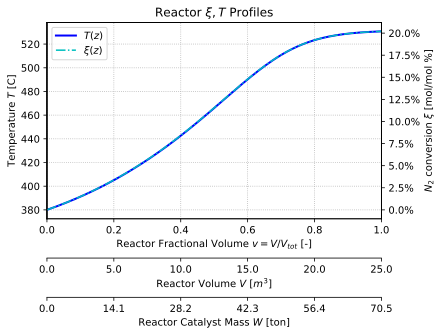

In [21]:
# figure
fig = plt.figure(figsize=(6,3.5))

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.1)

# main axis
ax1 = fig.add_subplot(111)

# set ticks
new_tick_locations = np.linspace(0.,1.,6)

# put axis for x = volume
ax2 = ax1.twiny()
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.2))

# setting 
ax2.set_xlabel(r'Reactor Volume $V$ [$m^3$]')
#
def tick_fun_V(X):
    ''' 
    X is the volume fraction
    '''
    return ['%.1f' % z for z in Vrct*X]

ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_fun_V(new_tick_locations))

# put axis for x = mass
ax21 = ax1.twiny()
# Move twinned axis ticks and label from top to bottom
ax21.xaxis.set_ticks_position("bottom")
ax21.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax21.spines["bottom"].set_position(("axes", -0.4))

# setting 
ax21.set_xlabel(r'Reactor Catalyst Mass $W$ [ton]')
#
def tick_fun_W(X):
    ''' 
    X is the volume fraction
    '''
    return ['%.1f' % z for z in Vrct*X*rho_bed/1000.]

ax21.set_xticks(new_tick_locations)
ax21.set_xticklabels(tick_fun_W(new_tick_locations))

# put axis for y
ax3 = ax1.twinx()

# set primary x value
plt_x1 = vfrac_vec
# plt_x2 = V_vec
# plt_x3 = z_vec
# plt_x4 = Wcat_vec

# plotting for temp
line1, = ax1.plot(plt_x1,T_vec-273.15,'b-',linewidth=2,label=r'$T(z)$')
#
ax1.set_title(r'Reactor $\xi,T$ Profiles')
ax1.set_xlim(xmin=plt_x1[0],xmax=plt_x1[-1])
ax1.set_xlabel(r'Reactor Fractional Volume $v=V/V_{tot}$ [-]')
ax1.set_ylabel(r'Temperature $T$ [C]')
ax1.xaxis.grid(linestyle=':')
ax1.yaxis.grid(linestyle=':')

# plotting for conversion
line2, = ax3.plot(plt_x1,cnv_vec,'c-.',label=r'$\xi(z)$')
# 
values = ax3.get_yticks()
ax3.set_yticklabels(['{:,.1%}'.format(x) for x in values])
ax3.set_ylabel(r'$N_2$ conversion $\xi$ [mol/mol %]')

# final, legend and show
ax1.legend(handles=[line1, line2])
plt.show()

### Simulation 2: Reactor $x_{out,\mathit{NH3}},T$ Profiles given $V$

In this simulation, the outlet molar fraction of ammonia and temperature are plotted as a function of the reactor volume $V$.

In [22]:
# volume vector
Vplt_vec = np.linspace(0.,50.,50)   #[m3]

# alloc
xNH3_vec = np.zeros_like(Vplt_vec)
Tplt_vec = np.zeros_like(Vplt_vec)

# filling
i = 0
for v in Vplt_vec:
    # calc
    [_,_,_,_,cnv_vec2,T_vec2,_] = calc_rct(v,Fi_in,T_in,P_in,nu,Arct,dp,eps,rho_cat)

    cnv_out2 = cnv_vec2[-1]               #[-]
    #
    T_out2  = T_vec2[-1]                  #[K]
    x_out2  = calc_xz(cnv_out2,x_in,nu)   #[-]

    xNH3_vec[i] = x_out2[2]
    Tplt_vec[i] = T_out2
    
    i = i+1


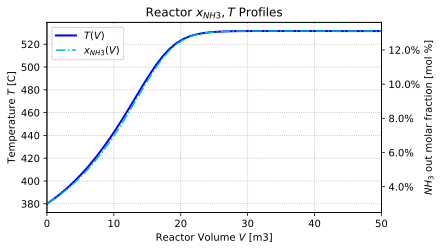

In [23]:
# figure
fig = plt.figure(figsize=(6,3.5))

# main axis
ax1 = fig.add_subplot(111)

# put axis for y
ax2 = ax1.twinx()

# plotting for temp
line1, = ax1.plot(Vplt_vec,Tplt_vec-273.15,'b-',linewidth=2,label=r'$T(V)$')
#
ax1.set_title(r'Reactor $x_{NH3},T$ Profiles')
ax1.set_xlim(xmin=Vplt_vec[0],xmax=Vplt_vec[-1])
ax1.set_xlabel(r'Reactor Volume $V$ [m3]')
ax1.set_ylabel(r'Temperature $T$ [C]')
ax1.xaxis.grid(linestyle=':')
ax1.yaxis.grid(linestyle=':')

# plotting for xNH3
line2, = ax2.plot(Vplt_vec,xNH3_vec,'c-.',label=r'$x_{NH3}(V)$')
# 
values = ax2.get_yticks()
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in values])
ax2.set_ylabel(r'$NH_3$ out molar fraction [mol %]')

# final, legend and show
ax1.legend(handles=[line1, line2])
plt.show()

### Simulation 3: Reactor $\xi,T$ Diagram

In this simulation, the different kinds of N2 conversion are plotted as a function of the temperature $T$.

It can be seen that $d\xi/d T$ is indeed a constant $k$, allowing the function $\xi=k(T-T_{in})$ to be a straight line reaching the equilibrium conversion.

In [24]:
# temperature vector
Tplt2_vec = np.linspace(350.+273.15,600.+273.15,100)

# alloc
cnvK_vec = np.zeros_like(Tplt2_vec)
cnvr_vec = np.zeros_like(Tplt2_vec)

# filling
i = 0
for t in Tplt2_vec:
    # calc
    cnvK_vec[i] = calc_cnveq(t,P_in,x_in,nu)
    cnvr_vec[i] = calc_cnvmaxr(t,P_in,x_in,nu)
    
    i = i+1


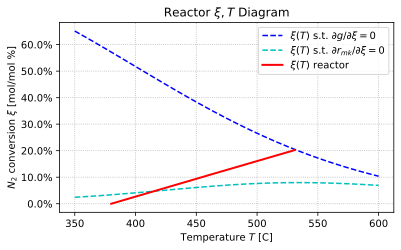

In [25]:
# figure
fig = plt.figure(figsize=(6,3.5))

# plot
plt.plot(Tplt2_vec-273.15,cnvK_vec,'b--',label=r'$\xi(T)$ s.t. $\partial g/\partial\xi=0$')

# get labels
locs, labels = plt.yticks()  
plt.yticks(locs, ['{:,.1%}'.format(x) for x in locs])

# other plots
plt.plot(Tplt2_vec-273.15,cnvr_vec,'c--',label=r'$\xi(T)$ s.t. $\partial r_{mk}/\partial\xi=0$')
plt.plot(T_vec-273.15    ,cnv_vec ,'r'  ,linewidth=2,label=r'$\xi(T)$ reactor')

plt.title(r'Reactor $\xi,T$ Diagram')
plt.xlabel(r'Temperature $T$ [C]')
plt.ylabel(r'$N_2$ conversion $\xi$ [mol/mol %]')
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Simulation 4: Reactor $\xi,T_{in}$ Diagram

In this simulation, the plot of the N2 conversion are plotted as a function of the inlet temperature $T_{in}$ at different pressures $P_{in}$.

In [26]:
# inlet temperature vector
Tinplt_vec = np.linspace(300.+273.15,450.+273.15,35)

# inlet pressure vector
Pinplt_vec = np.linspace(150.*101325.,350.*101325.,5)

# assign
cnvplt_vec = np.zeros((Tinplt_vec.size,Pinplt_vec.size))

# filling
j = 0
#
for pin in Pinplt_vec:

    i = 0 
    #
    for tin in Tinplt_vec:
        # calc
        [_,_,_,_,cnv_vec4,_,_] = calc_rct(Vrct,Fi_in,tin,pin,nu,Arct,dp,eps,rho_cat)
        
        cnvplt_vec[i,j] = cnv_vec4[-1]
        
        i = i+1
        
    j = j+1


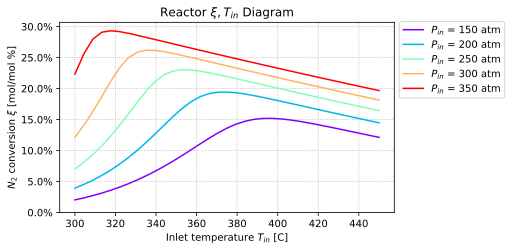

In [33]:
from matplotlib.pyplot import cm

# get color
color = iter(cm.rainbow(np.linspace(0, 1, Pinplt_vec.size)))

# figure
fig = plt.figure(figsize=(6,3.5))

# plots
for j in range(Pinplt_vec.size):
    c = next(color)
    plt.plot(Tinplt_vec-273.15,cnvplt_vec[:,j],c=c,label=r'$P_{in}$ = %.0f atm'%(Pinplt_vec[j]/101325.))
    
    if j==Pinplt_vec.size-2: locs, labels = plt.yticks() 
    
# get labels
plt.yticks(locs, ['{:,.1%}'.format(x) for x in locs])

plt.xlabel(r'Inlet temperature $T_{in}$ [C]')
plt.ylabel(r'$N_2$ conversion $\xi$ [mol/mol %]')
plt.title(r'Reactor $\xi,T_{in}$ Diagram')
plt.legend(loc='best',bbox_to_anchor=(1, 1.03))
plt.grid(linestyle=':')
plt.show()